In [2]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data
from models.EdgeNet import EdgeNet, NodeNet, EdgeNODE, W1W2Net, EdgeODENet
from torch.optim import Adam

c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# run only if new data is desired
ode_dim = 3
n_data = 4
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,10000)

dataset = []
for i in range(0,len(x_train)):
    dataset.append(to_pyg_data(x_train[i],y_train[i],ode_dim,n_data))

loader = DataLoader(dataset,batch_size=64,shuffle=True)

x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_data,128)

dataset = []
for i in range(0,len(x_test)):
    dataset.append(to_pyg_data(x_test[i],y_test[i],ode_dim,n_data))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)

In [3]:
def build_w1_w2(adjacencies, ode_dim):
    num_adj = adjacencies.size(0) // (2*(ode_dim * ode_dim))

    w_1, w_2 = adjacencies[:adjacencies.size(0) // 2], adjacencies[adjacencies.size(0) // 2:]

    Win = w_1.view(num_adj, ode_dim, ode_dim)
    Wout = w_2.view(num_adj, ode_dim, ode_dim)

    adjacencies = torch.empty(0)
    for i in range(0,Win.shape[0]):
        Ai = torch.mm(Wout[i],Win[i]).flatten()
        adjacencies = torch.cat((adjacencies, Ai))
        
    return adjacencies

In [8]:
model = EdgeODENet(n_data, ode_dim, 1)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()  # or MSELoss for regression
reg = torch.nn.L1Loss()

batch_size = 32

train_loss = []
test_loss = []

# initial test loss evaluation
with torch.no_grad():
    for data in test_loader:
        out = model(data)

        batch_size = data.batch.max().item() + 1

        adjacencies = build_w1_w2(out[:2*batch_size*ode_dim**2], ode_dim)

        loss = criterion(adjacencies, data.y)
        # print(loss.item())
        test_loss.append(loss)

        print(loss.item())

# Training loop
for epoch in range(2000):
    model.train()

    tr_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)

        x_T = data.x[:, :n_data].flatten()

        batch_size = data.batch.max().item() + 1

        # print(batch_size)

        adjacencies = build_w1_w2(out[:2*batch_size*ode_dim**2], ode_dim)

        loss = criterion(adjacencies, data.y)

        loss = loss + 0.01*criterion(out[2*batch_size*ode_dim**2:],x_T)
        # loss = loss + 0.0001*reg(adjacencies,0*adjacencies)
        train_loss.append(loss)

        loss.backward()
        optimizer.step()
        
        tr_loss += loss

    # print(tr_loss.item())

    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)

            batch_size = data.batch.max().item() + 1

            x_T = data.x[:, :n_data].flatten()

            adjacencies = build_w1_w2(out[:2*batch_size*ode_dim**2], ode_dim)

            loss = criterion(adjacencies, data.y)

            loss = loss + 0.01*criterion(out[2*batch_size*ode_dim**2:],x_T)
            # print(loss.item())
            test_loss.append(loss)

            print(loss.item())

1.7028121948242188
1.6718692779541016
1.485261082649231
1.2470617294311523
1.246516466140747
1.2245334386825562
1.2143501043319702
1.1925084590911865
1.1717982292175293
1.1670364141464233
1.1467838287353516
1.1385101079940796
1.11474609375
1.0996845960617065
1.0712358951568604
1.0556257963180542
1.0391428470611572
1.0188466310501099
1.002515435218811
0.9852254986763
0.9649413228034973
0.9485509395599365
0.930004358291626
0.9113449454307556
0.8940620422363281
0.8757860064506531
0.8615396618843079
0.8472830057144165
0.834270715713501
0.822921633720398
0.8120689988136292
0.8033839464187622
0.7983090877532959
0.7927165031433105
0.7862286567687988
0.7734116315841675
0.7653366327285767
0.7636013031005859
0.7553505897521973
0.7501315474510193
0.7447510361671448
0.7523086071014404
0.739088773727417
0.7456651329994202
0.7405636310577393
0.7391687631607056
0.7381697297096252
0.739128053188324
0.7352850437164307
0.7362052798271179
0.7339496612548828
0.7337704300880432
0.7338134050369263
0.7319672

KeyboardInterrupt: 

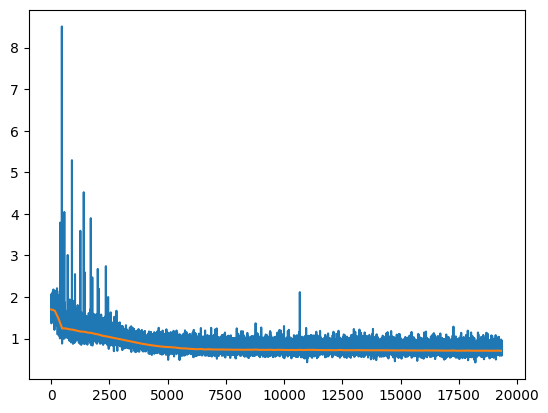

0.258
0.015
0.643
0.39725


In [9]:
import matplotlib.pyplot as plt

def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
tst_l = [test_loss[i].to('cpu').detach().numpy() for i in range(0,len(test_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.plot(range(0,len(loader)*len(tst_l),len(loader)),tst_l)
plt.show()

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,1000)

val_dataset = []

for i in range(0,len(x_val)):
    val_dataset.append(to_pyg_data(x_val[i],y_val[i],ode_dim,n_data))

val_loader = DataLoader(val_dataset)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    Ainit = get_adjacency(y_val[i])
    out = model(batch)
    Ahat = get_adjacency(build_w1_w2(out[:2*ode_dim**2], ode_dim)).t()
    # print(Ahat)
    A = get_adjacency(batch.y)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1
    

    if sum(abs(Ainit-A)) < 0.001:
        init_correct = init_correct+1

    for i in range(0,len(A)):
        
        if abs(Ainit[i]-A[i]) < 0.001:
             elem_wise_init += 1

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1
            
        elems_total += 1

print(correct/total)
print(init_correct/total)
print(elem_wise/elems_total)
print(elem_wise_init/elems_total)

In [ ]:
model = EdgeNet(n_data, 10, ode_dim ** 2, 1)
optimizer = Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.MSELoss()  # or MSELoss for regression
reg = torch.nn.L1Loss()

train_loss = []
test_loss = []

# Training loop
for epoch in range(1000):
    model.train()

    tr_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)

        loss = criterion(out.flatten(), data.y)
        # loss = loss + 0.0001*reg(out.flatten(),0*out.flatten())
        train_loss.append(loss)

        loss.backward()
        optimizer.step()
        
        tr_loss += loss

    print(tr_loss.item())

    
    with torch.no_grad():
        for data in test_loader:
            out = model(data)
            loss = criterion(out.flatten(), data.y)
            # print(loss.item())
            test_loss.append(loss)

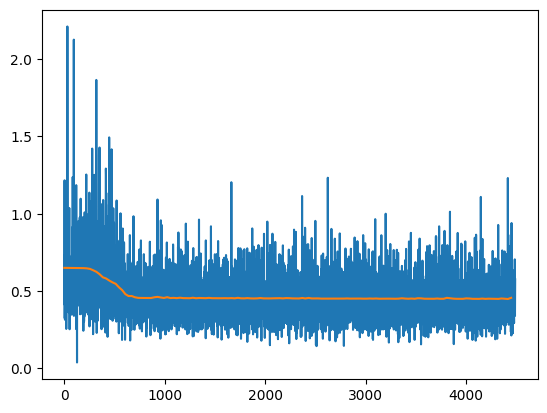

0.244
0.138
0.7175
0.50375


In [ ]:
import matplotlib.pyplot as plt

def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
tst_l = [test_loss[i].to('cpu').detach().numpy() for i in range(0,len(test_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.plot(range(0,len(loader)*len(tst_l),len(loader)),tst_l)
plt.show()

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,1000)

val_dataset = []

for i in range(0,len(x_val)):
    val_dataset.append(to_pyg_data(x_val[i],y_val[i],ode_dim,n_data))

val_loader = DataLoader(val_dataset)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    Ainit = get_adjacency(y_val[i])
    Ahat = get_adjacency(model(batch)).t()[0]
    A = get_adjacency(batch.y)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1
    

    if sum(abs(Ainit-A)) < 0.001:
        init_correct = init_correct+1

    for i in range(0,len(A)):
        
        if abs(Ainit[i]-A[i]) < 0.001:
             elem_wise_init += 1

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1
            
        elems_total += 1

print(correct/total)
print(init_correct/total)
print(elem_wise/elems_total)
print(elem_wise_init/elems_total)